In [ ]:
# import all packages

# %pip install qiskit 
# %pip install networkx
# %pip install pennylane 
# %pip install --upgrade "jax[cpu]"
# %pip install optax

In [2]:
import qiskit 
import numpy as np 
import matplotlib.pyplot as plt
from typing import Optional, Union, List, Callable, Tuple
import pennylane as qml 
import networkx as nx
from qiskit import IBMQ
from qiskit.providers.aer.noise import NoiseModel
from tqdm import tqdm
import jax 
import jax.numpy as jnp
import random
import optax 
from scipy.linalg import eigh

In [97]:
# Import all the hyper-parameters

class myargs: 
    def __init__(self) -> None:
        pass 

myargs.p =8
myargs.lr = 0.1
myargs.irrep = [6,6]
myargs.num_qubits = 12
myargs.num_yjms = 7
myargs.trotter_slice = 1
myargs.lattice_size = [3,4]
myargs.J = [1.0, 0.0]
myargs.iterations = 1000
myargs.TOKEN = "4c84e8146c0def626bb384424f78598ee055148df74863d4cbad29fb99d5e9cd4808077115561b6490f6dc4a0f8014b24fe5985003cdbb88c17a51c80c55279a" 
myargs.backend = 'ibmq_jakarta'
myargs.device = 0

#### Check the Exact Diagonal 



In [92]:
def getHam_square_frust(lattice_size: Union[int, list], J: Optional[Union[list, int]], get_matrix: bool=False):
    '''
    Build the Heisenberg Hamiltonian 
    '''
    graph = nx.generators.lattice.grid_2d_graph(lattice_size[0],lattice_size[1])
    graph = nx.relabel.convert_node_labels_to_integers(graph)
    A = np.array(nx.adjacency_matrix(graph).todense(), dtype=np.int32)
    # print(A)
    A2 = np.matmul(A, A)
    # print(A2)
    obs_J1 = []
    coeffs_J1 = []
    for edge in graph.edges():
        coeffs_J1.extend([1.0, 1.0, 1.0])
        obs_J1.extend([qml.PauliX(edge[0]) @ qml.PauliX(edge[1]),
                            qml.PauliY(edge[0]) @ qml.PauliY(edge[1]),
                            qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1])]) 
    second_edges = []
    for i in range(len(A2)): 
        for j in range(i):
            if A2[i, j] >0: 
                # print('asa')
                second_edges.append((i, j))
    coeffs_J2 = []
    obs_J2 = []
    for edge in second_edges:
        coeffs_J2.extend([1.0, 1.0, 1.0])
        obs_J2.extend([qml.PauliX(edge[0]) @ qml.PauliX(edge[1]),
                            qml.PauliY(edge[0]) @ qml.PauliY(edge[1]),
                            qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1])])
    
    # print(coeffs_J1)
    # print(coeffs_J2)
    # print(obs_J1)
    # print(obs_J2)
                 


    hamiltonian_heisenberg = qml.Hamiltonian(coeffs_J1, obs_J1) * J[0] + qml.Hamiltonian(coeffs_J2, obs_J2) * J[1]
    if get_matrix: 
        # matrix = 0
        # for coeff, op in zip(hamiltonian_heisenberg.coeffs, hamiltonian_heisenberg.ops):
        #     # print(op.matrix())
        #     matrix += coeff * np.real(op.matrix()).astype('float64')
        matrix = qml.utils.sparse_hamiltonian(hamiltonian_heisenberg).real.toarray()
        return matrix.astype('float64')
    return hamiltonian_heisenberg

ham_mat = getHam_square_frust(myargs.lattice_size, myargs.J, get_matrix=True)
# print(ham_mat.shape)
E_gs, V_gs = eigh(ham_mat.astype('float64'), subset_by_index=[0,1])
V_gs = V_gs[:,0]
e_gs = E_gs[0]
print(f'the complete spectrum: {E_gs}')
print('True Ground state Energy via ED :--- ({}) '.format(e_gs))

/tmp/ipykernel_5624/1675548589.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = np.array(nx.adjacency_matrix(graph).todense(), dtype=np.int32)


the complete spectrum: [-26.76672077 -24.67908852]
True Ground state Energy via ED :--- (-26.766720774059824) 


#### State Preparation 

In [34]:
# state preparation:

def state_init(irrep: list):

    num_bell = 2*  (irrep[0] - abs(irrep[0] - irrep[1]))
    # num_comp = abs(irrep[0] - irrep[1])
    for i in range(0, num_bell-1):
        qml.PauliX(wires=i)
        if i %2 ==0:
            qml.Hadamard(wires=i)
            qml.CNOT(wires=[i,i+1])
    qml.PauliX(wires=num_bell-1) 

#### The eSWAP layers consisting of even and odd adjanct transpositions

In [35]:
def _swap2pauli(i: int, j:int, mode='ham'): 
    '''
    using the formula: SWAP(i j) = Si . Sj + 1/2 I (without I ) 
    '''
    if mode=='ham':
        coeff = np.ones(3)
        hamiltonian = [qml.PauliX(wires=i) @qml.PauliX(wires=j), 
                    qml.PauliY(wires=i) @qml.PauliY(wires=j),
                    qml.PauliZ(wires=i) @qml.PauliZ(wires=j) ]
        return qml.Hamiltonian(coeff, hamiltonian)
    elif mode=='list':
        hamiltonian = [qml.PauliX(wires=i) @qml.PauliX(wires=j), 
                    qml.PauliY(wires=i) @qml.PauliY(wires=j),
                    qml.PauliZ(wires=i) @qml.PauliZ(wires=j) ]
        return hamiltonian

def coxeters(heis_params: jnp.array, layer:int, trotter_slice:int=myargs.trotter_slice): 
    '''
    if p is even, return evens 
    if p is odd, return odds
    '''
    if layer % 2 == 0: 
        for i, j  in zip(range(myargs.num_qubits), range(int(myargs.num_qubits / 2))):
            if i % 2 ==0 & i +1 < myargs.num_qubits:
                # print(f'j, i: {j, i}')
                swap = _swap2pauli(i, i+1, mode='ham')
                qml.ApproxTimeEvolution(swap, heis_params[j], trotter_slice)
    elif layer % 2==1:
        for i, j in zip(range(myargs.num_qubits), range(int(myargs.num_qubits / 2))):
            if i % 2 ==1 & i +1 < myargs.num_quibts:
                swap = _swap2pauli(i, i+1, mode='ham')
                qml.ApproxTimeEvolution(swap, heis_params[j], trotter_slice)

#### Hamiltonian Ansatz 


In [36]:
def var_ham_ans(heis_param: jnp.array, trotter_slice:int=myargs.trotter_slice): 
    hamiltonian = getHam_square_frust(myargs.lattice_size, myargs.J)
    return qml.ApproxTimeEvolution(hamiltonian,heis_param, trotter_slice )

#### Now the YJM Mixer Layer

In [37]:
def _get_YJM(idx:int):
    '''
    get YJM elements for a given index
    '''
    if idx == 0:
        print('too trivial choice')
        raise NotImplementedError
    elif idx ==1: 
        YJM = _swap2pauli(0,1, mode='ham')
        # print('---------')
        # print(YJM)
        return YJM
    else:
        swaps = []
        # yjm_lst = _swap2pauli(0, 1, mode='list')
        for i in range(idx):
            swaps.append(_swap2pauli(i, idx, mode='list'))
            # YJM += qml.SWAP(wires=[i, idx])
        # print(swaps)
        flat_yjm_lst = [item for sublist in swaps for item in sublist]
        # print(qml.Hamiltonian([1.0], [swaps[0]]))
        return qml.Hamiltonian(np.ones(len(flat_yjm_lst)), flat_yjm_lst)


def yjm_gates(yjm_params: jnp.array, trotter_slice:int=myargs.trotter_slice):
    # num_yjms = int(np.floor(num_qubits /3))
    # selection = np.random.randint(1, myargs.num_qubits, myargs.num_yjms)
    selection = random.sample(range(1, myargs.num_qubits), myargs.num_yjms)
    for i, sel in enumerate(selection):
        YJM = _get_YJM(sel)
        qml.ApproxTimeEvolution(YJM, yjm_params[i], trotter_slice)

#### Compiling the Circuits and perform measurements

In [38]:
def cqa_layers(params_dict:dict, trotter_slice:int=myargs.trotter_slice): 
    for layer in range(myargs.p):
        coxeters(params_dict['Heis'][layer], layer=layer, trotter_slice=trotter_slice)
        # var_ham_ans(params_dict['Heis'][layer,0], trotter_slice=trotter_slice)
        yjm_gates(params_dict['YJM'][layer], trotter_slice =trotter_slice)

In [45]:
# myargs.p =2
# myargs.lr = 0.01
# myargs.irrep = [2,2]
# myargs.num_qubits = 4
# myargs.num_yjms = 3
# myargs.trotter_slice = 1
# myargs.lattice_size = [2,2]
# myargs.J = [1.0, 0.0]
# myargs.iterations = 30
# myargs.TOKEN = "4c84e8146c0def626bb384424f78598ee055148df74863d4cbad29fb99d5e9cd4808077115561b6490f6dc4a0f8014b24fe5985003cdbb88c17a51c80c55279a" 
# myargs.backend = 'ibmq_jakarta'

In [67]:
def train_with_optimizer(cost_fn, optimizer: optax.GradientTransformation):
    '''
    update the gradient via jax 
    '''

    key = jax.random.PRNGKey(0)
    key1, key2 = jax.random.split(key)
    params_dict_init = {'YJM': jax.random.uniform(key1, (myargs.p, myargs.num_yjms)),
                    'Heis': jax.random.uniform(key2, (myargs.p,int(np.ceil(myargs.num_qubits/2))))}
    opt_state = optimizer.init(params_dict_init)
    loss_history, grad_history, param_history = [], [], [params_dict_init]
    # print('-------drawing the circuit--------')
    # drawer = qml.draw(cqa_circuit)
    # print(drawer(params_dict_init))
    # print(iteration)
    loss_grad_fn = jax.jit(jax.value_and_grad(cost_fn))
    for it in tqdm(range(1, myargs.iterations + 1)): 
        p_dict = param_history[-1]
        # print('p_dict | YJM: {} | Heis: {}'.format(p_dict['YJM'], p_dict['Heis']))
        loss, gradient = loss_grad_fn(p_dict)
        updates, opt_state = optimizer.update(gradient, opt_state, p_dict)
        # print(f'gradient: {gradient}')
        # print("Step {:3d}   Cost_L = {:9.7f}".format(it, loss))
        updated_p_dict = optax.apply_updates(p_dict, updates)
        # updated_p_dict = {'YJM': p_dict['YJM'] - myargs.lr * gradient['YJM'],
        #                 'Heis': p_dict['Heis'] - myargs.lr * gradient['Heis']}
        param_history.append(updated_p_dict)
        loss_history.append(loss)
        grad_history.append(gradient)
        if jnp.abs(loss - e_gs) < 0.05:
            print('desired convergence is reached')
            return loss_history, param_history, grad_history
        # if jnp.linalg.norm(gradient['Heis']) / gradient['Heis'].size < 1e-6:
        #     print(gradient['Heis'])
        #     print('encountering the Barren Plateau')
        #     break
    return loss_history, param_history, grad_history

#### Now we perform the circuit model with noise-free simulation

In [98]:
dev_mu = qml.device('default.qubit', wires=myargs.num_qubits)
@qml.qnode(dev_mu, interface='jax')
def cqa_circuit(params_dict: dict, check_symmetry:bool=False, trotter_slice:int=myargs.trotter_slice):
    state_init(myargs.irrep)
    cqa_layers(params_dict, trotter_slice=trotter_slice)
    # hamiltonian = getHam_square(myargs.lattice_size, myargs.J)
    if check_symmetry is False:
        hamiltonian = getHam_square_frust(myargs.lattice_size, myargs.J) 
        return qml.expval(hamiltonian)
    else: 
        su2_pauli = qml.PauliZ(0)
        for i in range(1, myargs.num_qubits):
            su2_pauli = su2_pauli @ qml.PauliZ(i) 
        return qml.expval(su2_pauli), qml.expval(qml.Identity(wires=0)) 

optimizer = optax.adamw(learning_rate=myargs.lr)
loss_history, param_history, grad_history = train_with_optimizer(cqa_circuit, optimizer)

  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_5624/1675548589.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = np.array(nx.adjacency_matrix(graph).todense(), dtype=np.int32)
2022-11-21 10:12:22.102243: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_cqa_circuit] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-11-21 10:23:12.867604: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 12m50.764945847s

********************************
[Compiling module jit_cqa_circuit] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
100%|██████████| 1000/1000 [15:15<00:00,  1

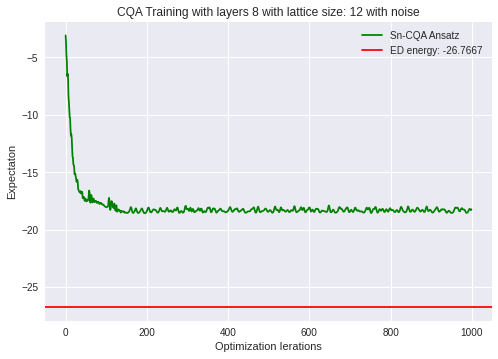

In [99]:
plt.style.use("seaborn")
plt.plot(loss_history, "g", label='Sn-CQA Ansatz')
plt.axhline(e_gs, color='r', linestyle='-', label='ED energy: {:.4f}'.format(e_gs))
plt.ylabel("Expectaton")
plt.xlabel("Optimization Ierations")

plt.legend(loc="upper right")
plt.title(f'CQA Training with layers {myargs.p} with lattice size: {myargs.num_qubits} with noise') 
plt.show()

In [77]:
# print(jnp.array(loss_history) )# plot convergence ierations
print(jnp.abs(jnp.min(jnp.array(loss_history)) - e_gs))

4.5111866


In [149]:
loss_history_12 = jnp.array(loss_history)

#### Now we perform the quantum simulation with noise

#### Comparison with the Jax implementation 

Note that JAX implementation uses full YJMs and heiseneberg evolution, resulting in n^4 scaling. However, The Circuit level uses n^2 scaling with only the first order YJM and (optional) eSWAPs

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('../codes/'))
if module_path not in sys.path:
    sys.path.append(module_path)

Irrep Dims for [2, 2]: --- 2
now the gradient phase


100%|██████████| 30/30 [00:11<00:00,  2.68it/s]


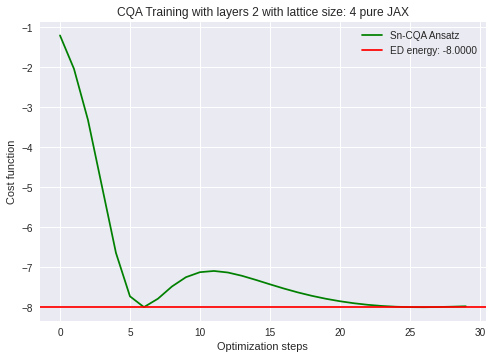

loss hostory with pure JAX and 2-nd YJM: [-1.20129103 -2.03788067 -3.31674803 -4.97775025 -6.64240352 -7.72753936
 -7.99750699 -7.78726379 -7.48169721 -7.2488887  -7.12379179 -7.09341498
 -7.13202523 -7.21373831 -7.31716645 -7.42682314 -7.5328307  -7.62976067
 -7.71522273 -7.78860425 -7.85014124 -7.90034315 -7.93971738 -7.96871829
 -7.98784795 -7.99783676 -7.99982814 -7.99548811 -7.98697328 -7.97672945]


In [31]:
from optimization import CSnGradient


lattice4 =[[(1,2), (1,8), (2,3), (2,7), (3,4), (3,6), (4,5), (5,6), (5, 12),
            (6,7), (6, 11), (7, 10), (7, 8), (8,9), (9, 10), (10, 11), (11, 12)],

           [(1,3), (1,9), (1,7), (2,4), (2,8), (2, 10), (2, 6), (3, 11), (3,5), (3,7),
            (4, 12), (4, 6), (5, 7), (5, 11), (6, 8), (6, 10), (6, 12),  (7, 9), (7, 11), (8, 10),
            (9, 11), (10, 12)]]
lattice_simple = [[(1, 2), (2, 3), (3, 4), (1, 4)]]
# partit = [int(6),int(6)]
# Nsites = int( 12)    

CsnFourier = CSnGradient(J= myargs.J, 
                        lattice = lattice_simple, 
                        Nsites=myargs.num_qubits,
                        partit=[2,2] ,p=myargs.p, num_samples =int(1000), max_iter = myargs.iterations, lr=myargs.lr)


# Ham_rep = CsnFourier.Ham_rep()

# print(CsnFilters.rep_mat_H)
# E_gs, V_gs = eigh(Ham_rep.astype('float64'), subset_by_index=[0,1])
# V_gs = V_gs[:,0]
# E_gs = E_gs[0]
# V_gs = jnp.asarray(V_gs)
# print('True Ground state Energy via ED for partition {}:--- ({}) '.format(myargs.irrep, E_gs))
# print('True Ground State wavefuncion in Sn irrep basis for partition {}:--- {}'.format(partit, V_gs))

print('Irrep Dims for {}: --- {}'.format(myargs.irrep, CsnFourier.dim))

print('now the gradient phase')


optimizer = optax.adamw(learning_rate=myargs.lr)
loss_history_jax, param_history_jax =CsnFourier.train(optimizer)
loss_history_jax = jnp.array(loss_history_jax) * 4.0
# print(loss_history)
plt.style.use("seaborn")
plt.plot(loss_history_jax , "g", label='Sn-CQA Ansatz')
plt.axhline(e_gs, color='r', linestyle='-', label='ED energy: {:.4f}'.format(e_gs))
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.legend(loc="upper right")
plt.title(f'CQA Training with layers {myargs.p} with lattice size: {myargs.num_qubits} pure JAX') 
plt.show()
# plt.savefig(f'Figures/CQA_p{myargs.p}_lattice{myargs.num_qubits}')  
print(f'loss hostory with pure JAX and 2-nd YJM: {loss_history_jax}')


#### Benchmark with the Hardware efficient ansatz

Use the pennylane's highly entangled layers 

  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_5624/1675548589.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = np.array(nx.adjacency_matrix(graph).todense(), dtype=np.int32)
2022-11-21 00:41:41.802413: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 42m51.517137313s

********************************
[Compiling module jit_circuit_hea] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
100%|██████████| 1000/1000 [45:16<00:00,  2.72s/it]   


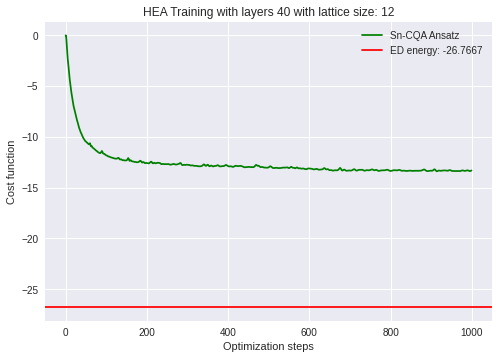

In [29]:
hea_num_layer = 40
hea_lr = 0.1
hea_iterations = 1000
# myargs.num_qubits = 4
# myargs.lattice_size = [2,2]

dev = qml.device('default.qubit', wires=myargs.num_qubits)

@qml.qnode(dev, interface='jax')
def circuit_hea(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=[i for i in range(myargs.num_qubits)])
    hamiltonian = getHam_square_frust(myargs.lattice_size, myargs.J)
    return qml.expval(hamiltonian)


optimizer = optax.adamw(learning_rate=hea_lr)
shape = qml.StronglyEntanglingLayers.shape(n_layers=hea_num_layer, n_wires=myargs.num_qubits)
# weights = np.random.random(size=shape)
key = jax.random.PRNGKey(0)
weights_init = jax.random.uniform(key, shape)
loss_history_hea, grad_history_hea, param_history_hea = [], [], [weights_init]
opt_state = optimizer.init(weights_init)
loss_grad_fn = jax.jit(jax.value_and_grad(circuit_hea))
for it in tqdm(range(1, hea_iterations + 1)): 
    weights = param_history_hea[-1]
    loss, gradient = loss_grad_fn(weights)
    updates, opt_state = optimizer.update(gradient, opt_state, weights)
    updated_weights = optax.apply_updates(weights, updates)
    param_history_hea.append(updated_weights)
    loss_history_hea.append(loss)
    grad_history_hea.append(gradient)
    if jnp.abs(loss - e_gs) < 0.05:
        print('desired convergence is reached')
        break
    
plt.style.use("seaborn")
plt.plot(loss_history_hea , "g", label='Sn-CQA Ansatz')
plt.axhline(e_gs, color='r', linestyle='-', label='ED energy: {:.4f}'.format(e_gs))
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.legend(loc="upper right")
plt.title(f'HEA Training with layers {hea_num_layer} with lattice size: {myargs.num_qubits}') 
plt.show()
# plt.savefig(f'Figures/CQA_p{myargs.p}_lattice{myargs.num_qubits}')  
    

In [132]:
data4 = np.load('/local/hanzheng/CQA/Sn_CQA/pennylane_codes/Figures/loss_with_[3, 4].npy')

np.where(data4 <= -26.07) 




(array([360, 370, 371, 382, 383, 384, 395, 396, 397, 398, 399, 400, 401,
        402, 403, 414, 415, 470, 477, 478]),)

In [119]:
print((jnp.min(jnp.array(loss_history_hea)) -e_gs ) )


13.382594


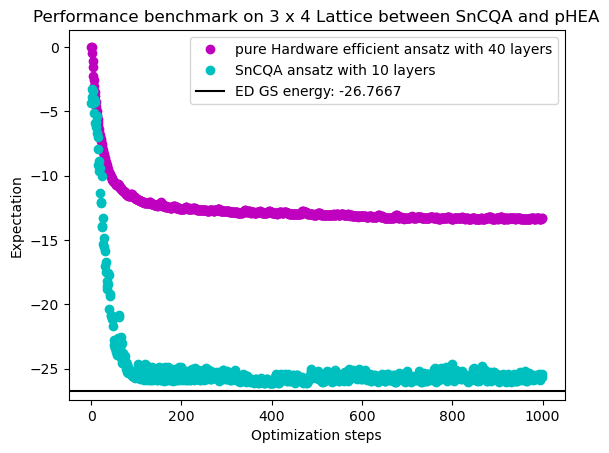

In [112]:
# final comparison with all the methods

plt.style.use("default")
plt.plot(loss_history_hea , "mo", label=f'pure Hardware efficient ansatz with {hea_num_layer} layers')
# plt.plot(loss_history_noise , "b", label='Sn-CQA Ansatz with noise')
# plt.plot(loss_history_jax , "b", label=f'Sn-CQA Ansatz in pure jax with {myargs.p} layers')
plt.plot(data4 , "co", label='SnCQA ansatz with 10 layers')
plt.axhline(e_gs, color='k', linestyle='-', label='ED GS energy: {:.4f}'.format(e_gs))
plt.ylabel("Expectation")
plt.xlabel("Optimization steps")
plt.legend(loc="upper right")
plt.title(f'Performance benchmark on 3 x 4 Lattice between SnCQA and pHEA') 
plt.show()

In [1]:
plot_data1 = dict()
plot_data1['CQA'] = [1, 3, 4, 6] #lattice_size vs. layers
plot_data1['HEA'] = [4, 10, 20, 40] 
plot_data2 = dict() # lattice_size vs. convergence time
plot_data2['CQA'] = [16, 27, 65, ]
plot_data2['HEA'] = [33, 55, 219, 1000 ]


/tmp/ipykernel_4147/4131404953.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = np.array(nx.adjacency_matrix(graph).todense(), dtype=np.int32)


the complete spectrum: [-21.4247588 -19.6529526]
True Ground state Energy via ED :--- (-5.356189701087753) 


#### Plot the major plots

TypeError: ufunc 'sqrt' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

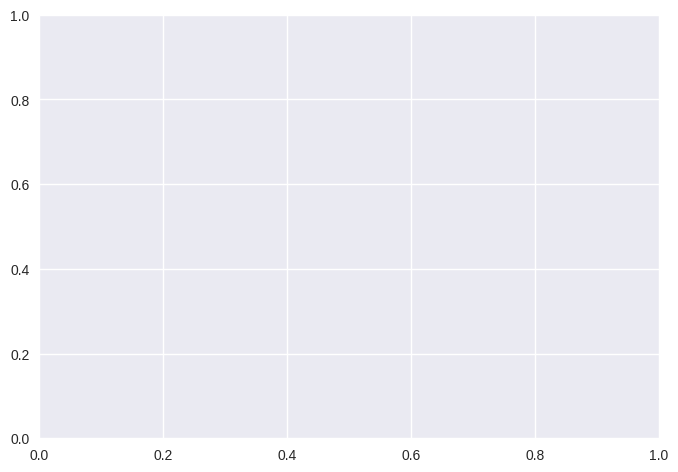

In [83]:
# plt.style.use("default")
# plt.style.use("seaborn")
plt.scatter([4, 6, 8, 12], plot_data1['CQA'] , "bo",linestyle='-' ,label='Sn-CQA Ansatz')
# plt.plot(loss_history_noise , "b", label='Sn-CQA Ansatz with noise')
plt.scatter([4, 6, 8, 12], plot_data1['HEA'] , "ro",linestyle='-' ,label='Hardware-efficient ansatz')
# plt.plot(loss_history_hea , "m", label=f'Hardware efficient ansatz with {hea_num_layer} layers')
# plt.axhline(e_gs, color='k', linestyle='-', label='ED GS energy: {:.4f}'.format(e_gs))
plt.ylabel("Number of Layers")
plt.xlabel("Number of qubits")
plt.legend(loc="best")
plt.ylim([0, 30])
# plt.title('') 
plt.show()

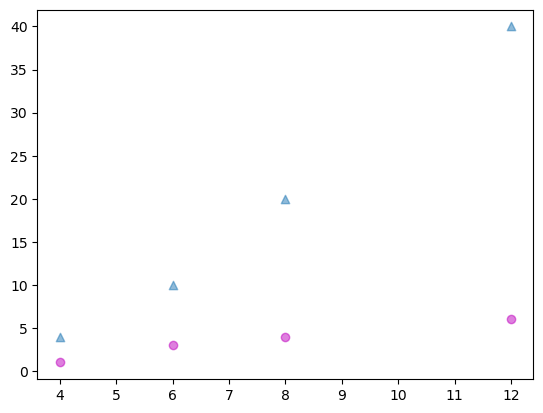

In [121]:

plt.style.use("default")
area = (10 * np.random.rand(8))**2  # 0 to 15 point radii
colors = np.sqrt(area)

plt.scatter([4, 6, 8, 12], plot_data1['CQA'], c='m'  ,alpha=0.5)
plt.scatter([4, 6, 8, 12], plot_data1['HEA'], marker='^', alpha=0.5)
plt.show()